<a href="https://colab.research.google.com/github/DJCordhose/transformers/blob/main/notebooks/de/drift_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drift Erkennung

Verändert sich die Verteilung von Ein- oder Ausabe?

In [42]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [44]:
import seaborn as sns
sns.__version__

'0.13.1'

In [45]:
if IN_COLAB:
  !pip install -q evidently==0.4.19
  # !pip install -q evidently

In [46]:
import evidently
evidently.__version__

'0.4.19'

In [47]:
from evidently.metrics import DatasetDriftMetric
from evidently.base_metric import InputData, ColumnMapping
from evidently.runner.loader import DataLoader, DataOptions
from evidently.calculations.data_drift import get_drift_for_columns
from evidently.options.data_drift import DataDriftOptions
from evidently.utils.data_operations import process_columns

# Aktuelle und ursprüngliche Trainings-Daten holen

Aktuelle Daten 3 Jahre nach Training

In [48]:
def url_for_dataset(relative_path):
  if IN_COLAB:
    url = f'https://github.com/DJCordhose/ml-for-business/raw/main/datasets/insurance_prediction/{relative_path}.csv.gz'
  else:
    url =  f'./datasets/insurance_prediction/{relative_path}.csv.gz'
  return url

In [49]:
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should starting to show

In [50]:
reference_dataset_url = url_for_dataset(f'reference')
current_dataset_url = url_for_dataset(f'monthly/month-{iteration}')

In [51]:
# could just as well be pandas code
reference_dataset = DataLoader().load(
   filename=reference_dataset_url,
   data_options = DataOptions(date_column=None, separator=';'),
)
reference_dataset = reference_dataset.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns')
reference_dataset.head()

,training,age,emergency_braking,braking_distance,power,milage
0,0,41.951100,0,40.933328,122.238329,98.509765
1,0,24.368286,1,44.797317,113.765298,46.324178
2,0,18.314649,1,41.587241,143.427269,76.862968
3,0,51.265254,1,47.266716,111.578133,102.697069
4,0,23.578861,0,42.835319,145.994235,63.690055


In [52]:
# could just as well be pandas code
current_dataset = DataLoader().load(
   filename=current_dataset_url,
   data_options = DataOptions(date_column=None, separator=';'),
)
current_dataset = current_dataset.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns')
current_dataset.head()

,training,age,emergency_braking,braking_distance,power,milage
0,0,45.700860,1,33.730669,118.306787,92.429050
1,0,53.091268,1,35.575746,168.151487,53.595707
2,1,41.989477,1,37.515860,104.683894,40.402020
3,0,41.792728,1,44.043184,143.531543,46.462029
4,1,28.679302,1,34.329172,85.439495,39.791829


# Target / Prediction

In [53]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [54]:
if IN_COLAB:
    url = f'https://github.com/DJCordhose/ml-for-business/raw/main/notebooks/classifier-binary.keras'
    !wget {url}
model_path = 'classifier-binary.keras'

model = tf.keras.models.load_model(model_path)

--2024-05-14 11:26:23--  https://github.com/DJCordhose/ml-for-business/raw/main/notebooks/classifier-binary.keras
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DJCordhose/ml-for-business/main/notebooks/classifier-binary.keras [following]
--2024-05-14 11:26:23--  https://raw.githubusercontent.com/DJCordhose/ml-for-business/main/notebooks/classifier-binary.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185706 (181K) [application/octet-stream]
Saving to: ‘classifier-binary.keras.1’

classifier-binary.k 100%[===================>] 181.35K  --.-KB/s    in 0.03s   

2024-05-14 11:26:23 (6.92 M

In [55]:
def prediction_name(value: int):
  names = ['BAD', 'GOOD']
  return names[value]

def predict(X):
  threshold = .5
  y_pred = (model.predict(X, verbose=0) > threshold).ravel().astype("int")
  return list(map(prediction_name, y_pred))


In [56]:
X = current_dataset
current_dataset_prediction = X.copy()
current_dataset_prediction['prediction'] = predict(X)
current_dataset_prediction.head()

,training,age,emergency_braking,braking_distance,power,milage,prediction
0,0,45.700860,1,33.730669,118.306787,92.429050,GOOD
1,0,53.091268,1,35.575746,168.151487,53.595707,BAD
2,1,41.989477,1,37.515860,104.683894,40.402020,GOOD
3,0,41.792728,1,44.043184,143.531543,46.462029,GOOD
4,1,28.679302,1,34.329172,85.439495,39.791829,GOOD


In [57]:
X = reference_dataset
reference_dataset_prediction = X.copy()
reference_dataset_prediction['prediction'] =  predict(X)
reference_dataset_prediction.head()

,training,age,emergency_braking,braking_distance,power,milage,prediction
0,0,41.951100,0,40.933328,122.238329,98.509765,BAD
1,0,24.368286,1,44.797317,113.765298,46.324178,BAD
2,0,18.314649,1,41.587241,143.427269,76.862968,BAD
3,0,51.265254,1,47.266716,111.578133,102.697069,BAD
4,0,23.578861,0,42.835319,145.994235,63.690055,BAD


# Welche Features driften?

In [58]:
column_mapping = ColumnMapping(
    categorical_features=['training', 'emergency_braking'],
    numerical_features=['age', 'braking_distance', 'power', 'milage'],
    prediction="prediction",
    target=None,
)
drift_share = 0.5
columns = column_mapping.categorical_features + column_mapping.numerical_features + [column_mapping.prediction]
columns

['training',
 'emergency_braking',
 'age',
 'braking_distance',
 'power',
 'milage',
 'prediction']

In [59]:
input_data = InputData(
    reference_data=reference_dataset_prediction,
    current_data=current_dataset_prediction,
    column_mapping=column_mapping,
    current_additional_features=None,
    data_definition=None,
    reference_additional_features=None,
    additional_data=None
)

In [60]:
dataset_columns = process_columns(input_data.reference_data, input_data.column_mapping)
dataset_columns

DatasetColumns(type='evidently.metric_results.DatasetColumns', utility_columns=DatasetUtilityColumns(type='evidently.metric_results.DatasetUtilityColumns', date=None, id=None, target=None, prediction='prediction'), target_type='cat', num_feature_names=['age', 'braking_distance', 'milage', 'power'], cat_feature_names=['training', 'emergency_braking'], text_feature_names=[], datetime_feature_names=[], target_names=None, task=None)

In [61]:
result = get_drift_for_columns(
    current_data=input_data.current_data,
    reference_data=input_data.reference_data,
    data_drift_options=DataDriftOptions(),
    drift_share_threshold=drift_share,
    dataset_columns=dataset_columns,
    columns=columns,
    agg_data = True
)

In [62]:
result.number_of_columns

7

In [63]:
result.number_of_drifted_columns

4

In [64]:
result.share_of_drifted_columns

0.5714285714285714

In [65]:
result.dataset_drift

True

In [66]:
for column in columns:
    drift = result.drift_by_columns[column]
    print(f'{column}: {drift.drift_score} ({drift.stattest_name}){", drifted" if drift.drift_detected else ""}')

training: 0.026168996995345487 (Jensen-Shannon distance)
emergency_braking: 0.431489050691815 (Jensen-Shannon distance), drifted
age: 0.33634057577174653 (Wasserstein distance (normed)), drifted
braking_distance: 0.07052872681963733 (Wasserstein distance (normed))
power: 0.027969027840461617 (Wasserstein distance (normed))
milage: 0.7140663279609664 (Wasserstein distance (normed)), drifted
prediction: 0.11162943229553653 (Jensen-Shannon distance), drifted


# Korrelationen im Vergleich

In [67]:
features = ['training', 'age', 'emergency_braking', 'braking_distance', 'power', 'miles', 'risk', 'prediction']

def plot_correlation(df, ax, title):
    df_corr = df.drop(columns=["group", "group_name", "good_customer"])

    cm = df_corr.corr()

    hm = sns.heatmap(cm,
                     ax=ax,
                    cbar=True,
                    annot=True,
                    square=True,
                    cmap='RdBu',
                    center=0,
                    fmt='.2f',
                    yticklabels=features,
                    xticklabels=features)

    ax.set_title(title, y=1.02, fontsize=18);

In [68]:
import pandas as pd

threshold = .5

df_reference = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
df_reference["prediction"] = (model.predict(reference_dataset, verbose=0) > threshold).ravel().astype("int")

df_iteration = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')
df_iteration["prediction"] = (model.predict(current_dataset, verbose=0) > threshold).ravel().astype("int")

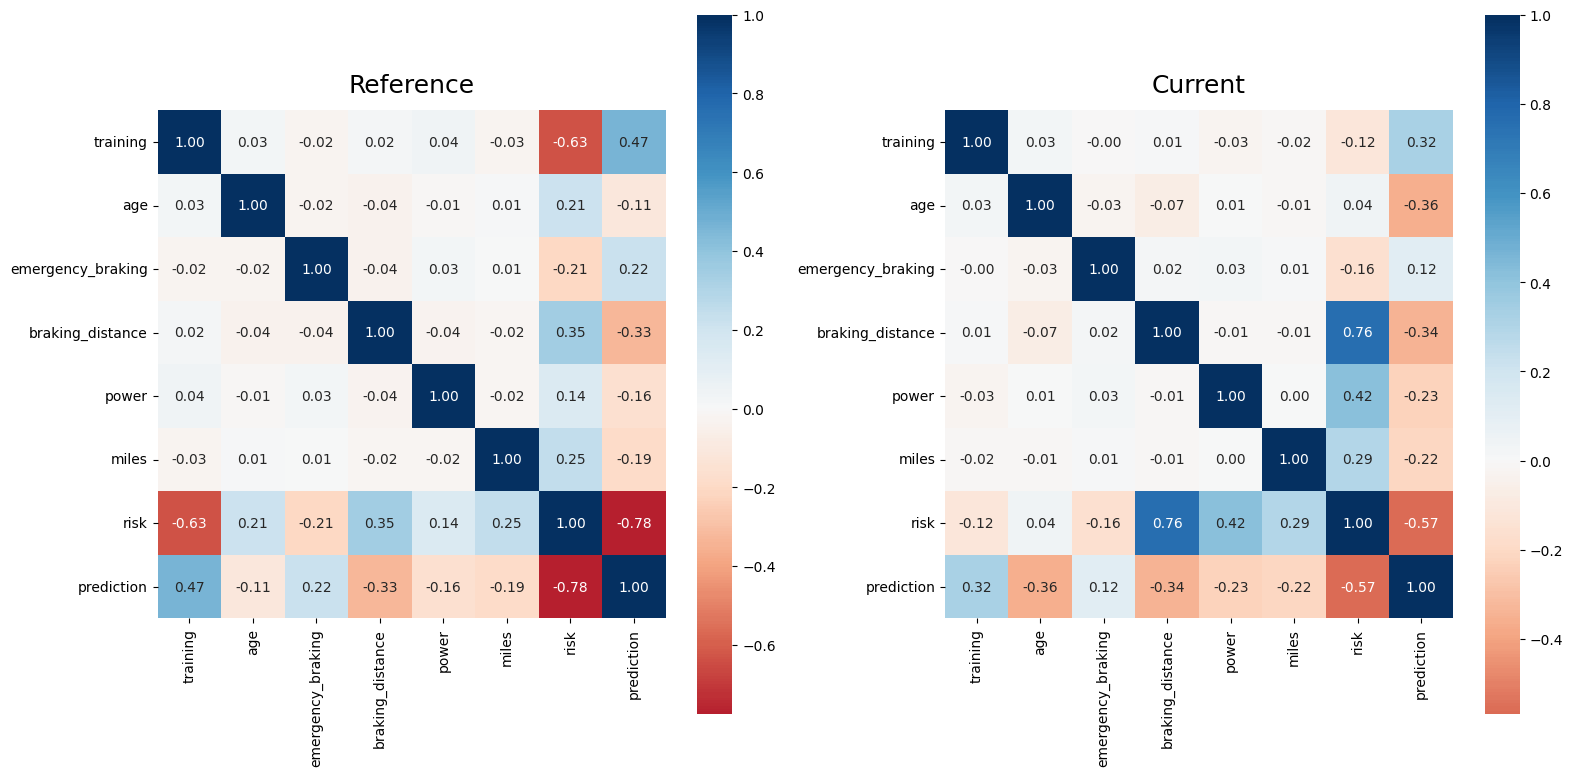

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

plot_correlation(df_reference, ax1, "Reference")
plot_correlation(df_iteration, ax2, "Current")
plt.tight_layout()


# Kompletter Report

In [70]:
df_iteration_X = df_iteration.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns')
df_reference_X = df_reference.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns')

In [ ]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

report = Report(metrics=[
   DataDriftPreset(),
])

report.run(reference_data=df_reference_X, current_data=df_iteration_X)
report.show(mode='inline')

# Beobachtungen / Interpretation

* weniger schlechte Fahrer
* Die gesellschaft altert
* Leute fahren weniger
* Die Fähigkeiten der Fahrer sind weniger wichtig
* Fast alle Fahrzeuge haben ein Notbremsystem


# Maßnahme

1. ~~Nichts tun~~
1. ~~Model EOL, Fallback auf Regelsystem~~
1. _Re-Train_
1. _Re-Engineer_
1. _Re-Calibrate_

*Im Detail*
* Neu-Trainieren mit dem neuesten Datensatz, aber
  * Nur noch Fahrzeuge mit Notbremssystem für das Training nutzen und
  *  Notbremssystem als nutzloses Feature aus dem Training herausnehmen
* Threshold für Akzeptanz als Kunde neu kalibrieren
* Einen höhreren Anteil an Versicherten wagen  